# This file is generally to work out the absorption coefficient $I(\vec{k},\vec{G})$

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
import astropy.units as unit
import astropy.constants as const
import itertools
import plotly.express as px

In [2]:
#Define known physical constants
a_nai = 6.642 #Lattice constant, Angstroms = 1e-10m, from Dent paper. 
hbar_kevs = (const.hbar.to(unit.keV*unit.s)).value #hbar, keV*s, from astropy
c_aas = (const.c.to(unit.AA/unit.s)).value #speed of light, angstrom/s (cancels with a), from astropy
me_hca = (const.m_e/((const.hbar/(const.c*unit.AA)).si)).value #Electron mass, in units of... hbar/(c*AA) to cancel with |G| (LMAOOOOO)

In [3]:
# Define unknown constants/crystal info
g_agg = 1e-10 #g_agg (axion-photon-photon) coupling constant; in GeV^(-1) (for photon coalescence)
g_ag = 1e-10 #Axion-photon coupling (Primakoff process), in GeV^(-1).
#Upper bound on g_ag of 2.7e-10 from the Sun, see Di Luzio's review
lmda = (g_agg/(1e-8))**4
phi_0 = 5.95e14 #in cm^(-2) s^(-1)
E_0    = 1.103 #in keV

#Crystal Geometry
diam = 110*unit.mm
hgt = 150*unit.mm 
vol = ((np.pi*(diam/2)**2*hgt).to(unit.AA**3)).value #Crystal volume, in AA^3

vol_cell = 67.71 #In AA^3, from Dent paper

In [4]:
#Define useful functions

def make_hkl(max_h=5,max_k=5,max_l=5, s=False):
    output_list = []
    for h in range(max_h+1):
        for k in range(max_k+1):
            if k%2 == h%2:
                for l in range(max_l+1):
                    if l%2 == h%2:
                        if s:
                            if l%2 == 0:
                                output_list.append((h,k,l))
                        else:
                            output_list.append((h,k,l))
    return np.array(output_list[1:])

def mod2(vec3):
    '''Returns the dimensionless magnitude of an array of vectors in the (h,k,l) basis. Factor of 2pi/a has to be multiplied manually'''
    return 3*(vec3[:,0]**2 + vec3[:,1]**2 + vec3[:,2]**2) - 2*(vec3[:,0]*vec3[:,1] + vec3[:,1]*vec3[:,2] + vec3[:,2]*vec3[:,0])

def gdotk(hkl_arr):
    '''Returns gHAT dot kHAT'''
    return (-hkl_arr[:,0]+hkl_arr[:,1]+hkl_arr[:,2])/np.sqrt(mod2(hkl_arr)) #IJBOL -- you can't just say ijbol

def w_func(Ea, dVector = False, Delta=1.5, E1=1, E2=6):
    '''Returns array of W(Ea, Delta, E1, E2) where everything is in keV. Infinite Ea is dealt with'''
    w_list = []
    if dVector:
        entangle = np.dstack((Ea, Delta))
        for index in range(entangle.shape[1]):
            E = entangle[0,index,0]
            D = entangle[0,index,1]
            if np.isinf(E):
                w_list.append(0)
            else:
                w = (1/2)*(erf((E-E1)/(np.sqrt(2)*D)) - erf((E-E2)/(np.sqrt(2)*D)))
                w_list.append(w)
    else:
        for E in Ea:
            if np.isinf(E):
                w_list.append(0)
            else:
                w = (1/2)*(erf((E-E1)/(np.sqrt(2)*Delta)) - erf((E-E2)/(np.sqrt(2)*Delta)))
                w_list.append(w)
    return np.array(w_list)

def make_dpde(Energy_array):
    '''Creates dPhi/dE for the parametrised blackbody-like form appearing in older papers. Assumes no axion mass.
    Units of cm^(-2) s^(-1) keV^(-1)'''
    dpdt_list = []
    for E in Energy_array:
        if np.isinf(E):
            dpdt_list.append(0)
        else:
            dpdt_list.append(np.sqrt(lmda)*(phi_0)/(E_0) * (E/E_0)**3/(np.exp(E/E_0)-1))
    return np.array(dpdt_list)

def hkl_to_cart(hkl_array):
    '''Converts from hkl basis to cartesian basis, ignoring factor of 2pi/a'''
    x_axis = - hkl_array[:,0] + hkl_array[:,1] + hkl_array[:,2] 
    y_axis =   hkl_array[:,0] - hkl_array[:,1] + hkl_array[:,2] 
    z_axis =   hkl_array[:,0] + hkl_array[:,1] - hkl_array[:,2] 
    return np.stack((x_axis, y_axis, z_axis), axis=1)

In [5]:
hkl = make_hkl(s=True)
hkl_c = hkl_to_cart(hkl)

In [6]:
g_cart = hkl_c*2*np.pi/a_nai #in AA^(-1)

In [28]:
def one_cube(a):
    '''Creates an array of 3d points representing one cell in an FCC lattice'''
    return np.array([(0,0,0),(a,0,0),(0,0,a),(a,0,a),
            (0,a,0),(a,a,0),(0,a,a),(a,a,a),
            (0,a/2,a/2), (a/2,0,a/2), (a/2,a/2,0),
            (a,a/2,a/2), (a/2,a,a/2), (a/2,a/2,a)])

In [29]:
def make_lattice_points(cell_vec = (10,10,10), a = a_nai):
    #Number of points is almost exactly O(n^3)
    nx = cell_vec[0]
    ny = cell_vec[1]
    nz = cell_vec[2]    

    all_points = one_cube(a) #Initial cube
    init_list = list(itertools.product(range(nx),range(ny),range(nz)))
    
    for start_vec in init_list:
        extend_table = np.repeat(np.array([start_vec]), 14, axis=0)
        points = np.array(one_cube(a)) + extend_table
        all_points = np.vstack((all_points, points))
    return np.unique(all_points, axis=0)

In [142]:
idk = 100*make_lattice_points(cell_vec=(5,
                                        5,
                                        5))

In [49]:
len(idk)

1750

In [50]:
idk

array([[   0. ,    0. ,    0. ],
       [   0. ,    0. ,  100. ],
       [   0. ,    0. ,  200. ],
       ...,
       [1064.2, 1064.2,  864.2],
       [1064.2, 1064.2,  964.2],
       [1064.2, 1064.2, 1064.2]])

In [51]:
erm = []

for vec1 in idk:
    for vec2 in idk:
        erm.append(vec1-vec2)

erm = np.array(erm)
#47.1s when n=7^3

In [52]:
erm

array([[   0.,    0.,    0.],
       [   0.,    0., -100.],
       [   0.,    0., -200.],
       ...,
       [   0.,    0.,  200.],
       [   0.,    0.,  100.],
       [   0.,    0.,    0.]])

In [53]:
kr = erm[:,0]
kr_plus = kr[kr>0]
np.sum(np.exp(-np.abs(kr_plus)))

5.729505428511119e-10

In [56]:
np.arange(0,5,1)

array([0, 1, 2, 3, 4])

In [57]:
np.arange(1/2,4+1/2,1)

array([0.5, 1.5, 2.5, 3.5])

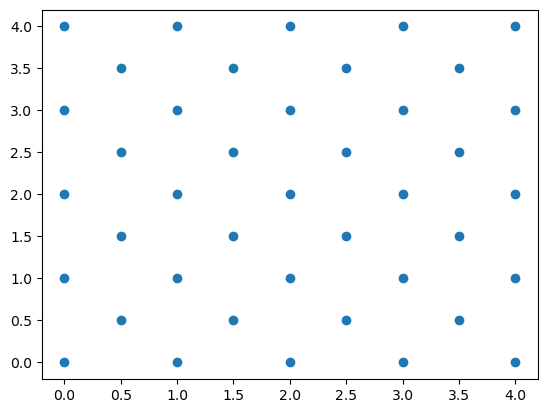

In [64]:
x_arr = np.arange(0,5,1)
y_arr = np.arange(0,5,1)
product = np.array(list(itertools.product(x_arr, y_arr)))

hx_arr = np.arange(0.5,4.5, 1)
hy_arr = np.arange(0.5,4.5, 1)
h_product = np.array(list(itertools.product(hx_arr, hy_arr)))

n_grid = np.vstack((product,h_product))
plt.scatter(n_grid[:,0], n_grid[:,1])

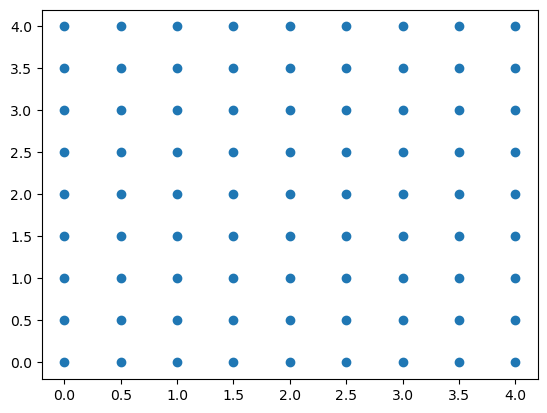

In [94]:
full_grid = np.array(tuple(itertools.product(np.arange(0,4.5,0.5),
                                             np.arange(0,4.5,0.5))))

plt.scatter(full_grid[:,0], 
            full_grid[:,1])

In [85]:
make_tuples = lambda grid:  [ tuple(x) for x in grid.tolist()]

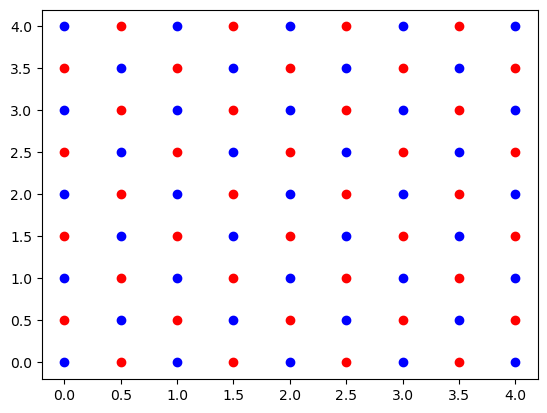

In [97]:
err = set(make_tuples(full_grid)) - set(make_tuples(n_grid))
er2 = np.array(list(err))

plt.scatter(er2[:,0], 
            er2[:,1], color='red')

plt.scatter(n_grid[:,0],
            n_grid[:,1], color='blue')

In [128]:
full_grid_3d = np.array(tuple(itertools.product(np.arange(0,4.5,0.5),
                                                np.arange(0,4.5,0.5),
                                                np.arange(0,4.5,0.5))))

In [127]:
make_tuples(d3_h)

[(0.5, 0.5, 0.0),
 (0.5, 0.5, 1.0),
 (0.5, 0.5, 2.0),
 (0.5, 0.5, 3.0),
 (0.5, 0.5, 4.0),
 (0.5, 1.5, 0.0),
 (0.5, 1.5, 1.0),
 (0.5, 1.5, 2.0),
 (0.5, 1.5, 3.0),
 (0.5, 1.5, 4.0),
 (0.5, 2.5, 0.0),
 (0.5, 2.5, 1.0),
 (0.5, 2.5, 2.0),
 (0.5, 2.5, 3.0),
 (0.5, 2.5, 4.0),
 (0.5, 3.5, 0.0),
 (0.5, 3.5, 1.0),
 (0.5, 3.5, 2.0),
 (0.5, 3.5, 3.0),
 (0.5, 3.5, 4.0),
 (1.5, 0.5, 0.0),
 (1.5, 0.5, 1.0),
 (1.5, 0.5, 2.0),
 (1.5, 0.5, 3.0),
 (1.5, 0.5, 4.0),
 (1.5, 1.5, 0.0),
 (1.5, 1.5, 1.0),
 (1.5, 1.5, 2.0),
 (1.5, 1.5, 3.0),
 (1.5, 1.5, 4.0),
 (1.5, 2.5, 0.0),
 (1.5, 2.5, 1.0),
 (1.5, 2.5, 2.0),
 (1.5, 2.5, 3.0),
 (1.5, 2.5, 4.0),
 (1.5, 3.5, 0.0),
 (1.5, 3.5, 1.0),
 (1.5, 3.5, 2.0),
 (1.5, 3.5, 3.0),
 (1.5, 3.5, 4.0),
 (2.5, 0.5, 0.0),
 (2.5, 0.5, 1.0),
 (2.5, 0.5, 2.0),
 (2.5, 0.5, 3.0),
 (2.5, 0.5, 4.0),
 (2.5, 1.5, 0.0),
 (2.5, 1.5, 1.0),
 (2.5, 1.5, 2.0),
 (2.5, 1.5, 3.0),
 (2.5, 1.5, 4.0),
 (2.5, 2.5, 0.0),
 (2.5, 2.5, 1.0),
 (2.5, 2.5, 2.0),
 (2.5, 2.5, 3.0),
 (2.5, 2.5, 4.0),
 (2.5, 3.5

In [121]:
d3 = np.array(list(itertools.product(x_arr, y_arr, np.arange(0,5,1))))
d3_h = np.array(list(itertools.product(hx_arr, hy_arr, np.arange(0,5,1))))


lol = np.vstack((d3, d3_h))
lol

array([[0. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 0. , 2. ],
       [0. , 0. , 3. ],
       [0. , 0. , 4. ],
       [0. , 1. , 0. ],
       [0. , 1. , 1. ],
       [0. , 1. , 2. ],
       [0. , 1. , 3. ],
       [0. , 1. , 4. ],
       [0. , 2. , 0. ],
       [0. , 2. , 1. ],
       [0. , 2. , 2. ],
       [0. , 2. , 3. ],
       [0. , 2. , 4. ],
       [0. , 3. , 0. ],
       [0. , 3. , 1. ],
       [0. , 3. , 2. ],
       [0. , 3. , 3. ],
       [0. , 3. , 4. ],
       [0. , 4. , 0. ],
       [0. , 4. , 1. ],
       [0. , 4. , 2. ],
       [0. , 4. , 3. ],
       [0. , 4. , 4. ],
       [1. , 0. , 0. ],
       [1. , 0. , 1. ],
       [1. , 0. , 2. ],
       [1. , 0. , 3. ],
       [1. , 0. , 4. ],
       [1. , 1. , 0. ],
       [1. , 1. , 1. ],
       [1. , 1. , 2. ],
       [1. , 1. , 3. ],
       [1. , 1. , 4. ],
       [1. , 2. , 0. ],
       [1. , 2. , 1. ],
       [1. , 2. , 2. ],
       [1. , 2. , 3. ],
       [1. , 2. , 4. ],
       [1. , 3. , 0. ],
       [1. , 3. 

In [168]:
px.scatter_3d(x=make_3d_lattice_new()[:,0],
              y=make_3d_lattice_new()[:,1],
              z=make_3d_lattice_new()[:,2])

In [147]:
full_grid_3d

array([[0. , 0. , 0. ],
       [0. , 0. , 0.5],
       [0. , 0. , 1. ],
       ...,
       [4. , 4. , 3. ],
       [4. , 4. , 3.5],
       [4. , 4. , 4. ]])

In [165]:
def make_3d_lattice_new():
    output = []
    for triplet in full_grid_3d:
        if sum(triplet%1)%1 == 0:
            output.append(triplet)
    return np.array(output)

In [161]:
(full_grid_3d[16])

array([0. , 0.5, 3.5])

In [162]:
sum((full_grid_3d[16])%1)

1.0

In [166]:
make_3d_lattice_new() #THIS WORKS!

array([[0., 0., 0.],
       [0., 0., 1.],
       [0., 0., 2.],
       ...,
       [4., 4., 2.],
       [4., 4., 3.],
       [4., 4., 4.]])